In [1]:
import sys
thesis_code_path = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code'
sys.path.append(thesis_code_path)

In [3]:
import os
import torch
import numpy as np
from cycler import cycler
os.chdir('/Users/sandhyagiri/git/masterthesis')
import robust_priornet.utils.visualizer as vis
from robust_priornet.training.adversarial_trainer import get_optimal_threshold, get_optimal_threshold_wo_roc
from robust_priornet.attack_priornet import plot_mis_adv_success
from robust_priornet.attack_priornet import plot_ood_attack_success
from robust_priornet.eval.uncertainty import UncertaintyMeasuresEnum, UncertaintyEvaluator
from robust_priornet.eval.model_prediction_eval import ClassifierPredictionEvaluator
from robust_priornet.eval.misclassification_detection import MisclassificationDetectionEvaluator
from robust_priornet.eval.out_of_domain_detection import OutOfDomainDetectionEvaluator
from robust_priornet.utils.visualizer import plot_trio, get_common_indices
from robust_priornet.utils.misc import complete_roc_pr_attack_plots_ood2, check_tpr_fpr, check_tpr_fpr_attack
from robust_priornet.gen_adversarials import generate_adversarial_images
from matplotlib.ticker import FixedLocator, FixedFormatter
from threading import Timer
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
from textwrap import wrap
from PIL import Image
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_curve, precision_recall_curve

In [4]:
def figsize(scale, ratio_yx=None):
    fig_width_pt = 505.89 #397.48499  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27  # Convert pt to inch
    golden_mean = (np.sqrt(5.0) - 1.0) / 2.0  # Aesthetic ratio
    if ratio_yx is None:
        ratio_yx = golden_mean
    fig_width = fig_width_pt * inches_per_pt * scale  # width in inches
    fig_height = fig_width * ratio_yx  # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

In [5]:
def sns_facetsize(tot_width=0.95, ratio_yx_facet=1.6, nrows=1, ncols=1):
    ratio_yx = ratio_yx_facet * nrows / ncols
    size = figsize(tot_width, ratio_yx)
    height_facet = size[1] / nrows
    ratio_xy_facet = 1 / ratio_yx_facet
    return height_facet, ratio_xy_facet

In [6]:
# Customized newfig and savefig functions
def newfig(width, ratio_yx=None, style='whitegrid', subplots=True, nrows=1, ncols=1):
    sns.set(style=style, palette='colorblind', color_codes=True)
    
    if subplots:
        return plt.subplots(
                nrows, ncols,
                figsize=figsize(width, ratio_yx=ratio_yx))
    else:
        return plt.subplots(figsize=figsize(width, ratio_yx=ratio_yx))

In [7]:
def savefig(filename, fig=None, tight={'pad': 0.25},
        dpi=600, format='pgf', preview=None,
        close_fig=True, remove_preview_file_after=1, **kwargs):
    if fig is None:
        fig = plt.gca().figure
    if tight is not None:
        fig.tight_layout(**tight)
    if os.path.splitext(filename)[1] == format:
        filepath = filename
    else:
        filepath = f"{filename}.{format}"
        filepath2 = f"{filename}.pdf"
    #fig.savefig(filepath, dpi=dpi, **kwargs)
    fig.savefig(filepath2, dpi=dpi, **kwargs)
    if close_fig:
        if fig is None:
            plt.close()
        else:
            plt.close(fig)
    if preview is not None:
        if preview == format:
            preview_path = filepath
        else:
            while True:
                rnd_int = np.random.randint(np.iinfo(np.uint32).max)
                preview_path = f"preview_tmp{rnd_int}.{preview}"
                if not os.path.exists(preview_path):
                    break
            fig.savefig(preview_path, dpi=dpi, **kwargs)
            Timer(remove_preview_file_after, os.remove, args=[preview_path]).start()
        return IFrame(os.path.relpath(preview_path), width=700, height=500)

In [8]:
def get_plot_params():
    sns.set()
    
    color_list_p1 = sns.color_palette('inferno', 5)
    color_list_p2 = sns.color_palette('viridis', 5)
    color_list_p2.reverse()
    color_list = color_list_p1 + color_list_p2
    sns.palplot(color_list)
    sns.set_palette(color_list)
    
    # same settings for each plot --> change 
    color_dict = {'normal': 0, 'robust_conf': 1, 'robust_dentropy_out': 2, 'robust_dentropy': 3, 'robust_duncertainty_out': 4, 'robust_duncertainty': 5, 'rpn': 6, 'robust_dentropy_fixed_threshold': 7, 'robust_dentropy_batch': 8, 'robust_duncertainty_batch': 9}
    linestyle_dict = {'normal': ':', 'robust_conf': '-.', 'robust_dentropy_out': '-', 'robust_dentropy': '-', 'robust_duncertainty_out': '--', 'robust_duncertainty': '--', 'rpn': ':', 'robust_dentropy_fixed_threshold': '-', 'robust_dentropy_batch': '-','robust_duncertainty_batch': '--'}
    label_dict = {'normal': 'Normal',
                  'robust_conf': '$A_{\\mathrm{conf}}$',
    #              'robust_dentropy_out': '$A_{diffE_{o}}$',
    #              'robust_dentropy': '$A_{diffE}, eps=0.5$',
    #              'robust_duncertainty_out': '$A_{distU_{o}}$',
    #              'robust_duncertainty': '$A_{distU}, eps=0.5$',
    #              'rpn': 'RPN',
    #              'robust_dentropy_fixed_threshold': '$A_{diffE_{io}} eps=0.05$',
    #              'robust_dentropy_batch': '$A_{diffE}, eps=0.3$',
    #              'robust_duncertainty_batch': '$A_{distU}, eps=0.3$'
            }
    #color_dict = {'MNIST': 0, 'CIFAR10': 3, 'SVHN': 7}
    #linestyle_dict = {'MNIST': '-', 'CIFAR10': '-', 'SVHN': '-'}
    #label_dict = {'MNIST': 'MNIST', 'CIFAR10': 'CIFAR10', 'SVHN': 'SVHN'}


    # parameters for latex
    pgf_with_latex = {  # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
    "text.usetex": True,  # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],  # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,  # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 4,  # Make the legend/label fonts a little smaller
    "xtick.labelsize": 4,
    "ytick.labelsize": 4,
    "figure.figsize": figsize(0.9),  # default fig size of 0.9 textwidth
    "text.latex.preamble": [
        r"\usepackage[utf8]{inputenc}",  # use utf8 fonts
        r"\usepackage[T1]{fontenc}",
        r"\usepackage{amsmath}",
        r"\newcommand*{\mat}[1]{\boldsymbol{#1}}",
    ],
    "pgf.preamble": [
        r"\usepackage[utf8]{inputenc}",  # use utf8 fonts
        r"\usepackage[T1]{fontenc}",
        r"\usepackage{amsmath}",
        r"\newcommand*{\mat}[1]{\boldsymbol{#1}}",
        ],
    }
    mpl.rcParams.update(pgf_with_latex)
    # Set line widths
    default_params = {
        'grid.linewidth': 0.5,
        'grid.color': '.8',
        'axes.linewidth': 0.75,
        'axes.edgecolor': '.7',
    }
    #tight={'pad': 0.5}
    
    return color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict

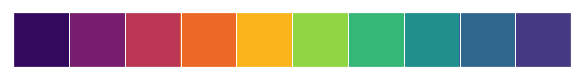

In [9]:
color_dict, color_list, linestyle_dict, *_ = get_plot_params()

In [10]:
def plot_curves(save_path, method_list, x_vals, y_list, plot_title, x_label='Epsilon', y_label='Success rate [\%]'):
    
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    plt.rcParams['lines.markersize'] = 0.2
    
    #plot results
    fig, ax = newfig(0.6)
    x_ticks = np.arange(0, len(x_vals), step=1)
    ax.minorticks_on()
    ax.set_xticks(x_ticks)
    ax.set_xticklabels((str(x) for x in x_vals), rotation="vertical", visible=True)
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.set_ylim((0.0,1.1))
    x_formatter = FixedFormatter(x_vals)
    x_locator = FixedLocator(x_ticks)
    ax.xaxis.set_major_formatter(x_formatter)
    ax.xaxis.set_major_locator(x_locator)
    for i in range(len(method_list)):   
        method = method_list[i]
        y_vals = y_list[i]

        label_method = label_dict[method]
        color_ind = color_dict[method]
        curr_style = linestyle_dict[method]

        ax.plot(y_vals, label=label_method, linestyle=curr_style, color=color_list[color_ind])
        x_ticks = [i for i in range(0, len(x_vals), 1)]
        ax.minorticks_on()
        x_formatter = FixedFormatter(x_vals)
        x_locator = FixedLocator(x_ticks)
        ax.xaxis.set_major_formatter(x_formatter)
        ax.xaxis.set_major_locator(x_locator)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xticks(x_ticks)
        xtick_labels = [str(x_vals[x]) for x in x_ticks]
        print(xtick_labels)
        ax.set_xticklabels(xtick_labels, rotation="vertical", visible=True)


    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.tick_params(axis='both', which='major', labelsize=9)
    #ax.tick_params(axis='both', which='minor', labelsize=9)
    #ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    ax.legend(loc=0) # 0 best, 1 upper right, 2 upper left, 3 lower left, 4 lower right, 5 right, 6 center ....
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #title = "\n".join(wrap(f'{plot_title}', 40))
    #print(title)
    ax.set_title(plot_title)
    # breakpoint()
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
    save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr)
    plt.close()
    
    mpl.rcParams.update(mpl.rcParamsDefault)

### Generate Epsilon curves

In [50]:
method_list = ['normal', 'robust_conf', 'robust_dentropy','robust_dentropy_out', 'robust_duncertainty', 'robust_duncertainty_out']
red_models = ['normal', 'robust_conf']

epsilon_curve_file_name = 'misclassify_success'
data_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/comparison-plots'
#data_dir= '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/comparison-plots'
#data_dir= '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/comparison-plots'

x_vals = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
y_list = []

for model in red_models:
    y_vals = np.loadtxt(os.path.join(data_dir, f"{epsilon_curve_file_name}_{model}.txt"))
    y_list.append(y_vals)

plot_curves(os.path.join(data_dir, 'PGD_L2_Classification_Attack_Success_mnist_models'), red_models, x_vals, y_list, 'Classification Attack using $m_{\\mathrm{conf}}$')


['0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
['0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']


In [152]:
method_list = ['normal']

epsilon_curve_file_name = 'precision_omniglot_out-in_l2_success'
data_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/comparison-plots'
#data_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/comparison-plots'
#data_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/comparison-plots'

x_vals = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
y_list = []

for i in range(len(method_list)):
    y_vals = np.loadtxt(os.path.join(data_dir, f"{epsilon_curve_file_name}_{method_list[i]}.txt"))
    y_list.append(y_vals)

plot_curves(os.path.join(data_dir, 'Figure_1_h_l2'), method_list, x_vals, y_list, 'Attacking precision: OMNIGLOT')


Attacking precision: OMNIGLOT


In [46]:
# summary attack success plot (classification) attack for all models
method_list = ['normal', 'robust_conf', 'robust_dentropy','robust_dentropy_out', 'robust_duncertainty', 'robust_duncertainty_out']
model = 'normal'


epsilon_curve_file_name = 'misclassify_success'
data_dir = {
    'MNIST': '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/comparison-plots',
    'SVHN': '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/comparison-plots',
    'CIFAR10': '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/comparison-plots'
}
x_vals = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
y_list = []

for model_id in data_dir.keys():
    y_vals = np.loadtxt(os.path.join(data_dir[model_id], f"{epsilon_curve_file_name}_{model}.txt"))
    y_list.append(y_vals)

plot_curves(os.path.join('/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code', 'PGD_L2_Classification_Attack_Success_all_models'), list(data_dir.keys()), x_vals, y_list, 'Classification Attack using $m_{\mathrm{conf}}$')


/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [47]:
def plot_ood_attack_summary(save_path, data_dir, datasets=['mnist', 'omniglot', 'cifar10'], uncertainty_measures=['dentropy', 'duncertainty'], model_name='normal'):
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    plt.rcParams['lines.markersize'] = 0.2
    
    label_map = {
        'dentropy': '$m_{\mathrm{diffE}}$',
        'duncertainty': '$m_{\mathrm{distU}}$',
        'precision': '$m_{\mathrm{alpha_{0}}}$'
    }
    color_map = {
        'dentropy': color_list[0],
        'duncertainty': color_list[3],
        'precision': color_list[7]
    }
    # this sets the white background
    sns.set(style='whitegrid', palette='colorblind', color_codes=True)
    fig = plt.figure(figsize=figsize(0.9, ratio_yx=None))
    widths = [1] * 3
    heights = [1]
    spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    axes = []
    for i in range(3):
        if i > 0:
            ax = fig.add_subplot(spec[0, i], sharey=axes[0])
        else:
            ax = fig.add_subplot(spec[0, i])
        axes.append(ax)
        x_vals = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        for measure in uncertainty_measures:
            y_vals = np.loadtxt(os.path.join(data_dir, f"{measure}_{datasets[i]}_{'in-out' if i==0 else 'out-in'}_l2_success_{model}.txt"))
            print(len(y_vals))
            ax.plot(y_vals, color=color_map[measure], label=f'{label_map[measure]}')

        ax.set_title(datasets[i].upper(),fontsize=12)
        ax.set_xlabel('Epsilon', fontsize=12)
        if i==0:
            ax.set_ylabel('Success rate [\%]', fontsize=12)
        if i > 0:
            plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_ylim((0.0,1.1))
        x_ticks = [i for i in range(0, len(x_vals), 5)]
        ax.minorticks_on()
        x_formatter = FixedFormatter(x_vals)
        x_locator = FixedLocator(x_ticks)
        ax.xaxis.set_major_formatter(x_formatter)
        ax.xaxis.set_major_locator(x_locator)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xticks(x_ticks)
        xtick_labels = [str(x_vals[x]) for x in x_ticks]
        print(xtick_labels)
        ax.set_xticklabels(xtick_labels, rotation="vertical", visible=True)
        #ax.set_yticks(np.arange(0, 1.1, step=0.1))
        ax.legend(fontsize=12)
    
    #plt.setp(axes, title='ood-detection attacks on MNIST + OMNIGLOT model')
    plt.setp([a.get_xticklabels() for a in axes[:-1]], visible=True)
    save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr, fig=fig)
    plt.close()
    
    mpl.rcParams.update(mpl.rcParamsDefault)

In [52]:
# summary attack success plot (ood-detect) for one type model and various uncertainty measures
model = 'normal'

# probably add 'precision' later on
uncertainty_measures = ['dentropy', 'duncertainty', 'precision']
#data_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/comparison-plots'
#data_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/comparison-plots'
data_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/comparison-plots'
    
plot_ood_attack_summary(os.path.join(data_dir, 'PGD_L2_OOD_Detection_Attack_Success_svhn_model'), data_dir, datasets=['svhn', 'cifar10', 'cifar100'], uncertainty_measures=uncertainty_measures, model_name=model)


19
19
19
['0.01', '0.06', '0.2', '0.7']
19
19
19
['0.01', '0.06', '0.2', '0.7']
19
19
19
['0.01', '0.06', '0.2', '0.7']


/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [101]:
# ood-attack normal and adv models
def plot_ood_attack_model_summary(save_path, data_dir, datasets=['mnist', 'omniglot', 'cifar10'], uncertainty_measure='dentropy', models=['normal', 'rdiffe']):
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    plt.rcParams['lines.markersize'] = 0.2
    
    label_map = {
        'normal': 'Normal',
        'rdiffe': '$A_{\mathrm{diffE}}$',
        'rdiffe-ccat': '$CA_{\mathrm{diffE}}$',
        'rdistu': '$A_{\mathrm{distU}}$',
        'rdistu-ccat': '$CA_{\mathrm{distU}}$'
    }
    color_map = {
        'normal': color_list[0],
        'rdiffe': color_list[3],
        'rdiffe-ccat': color_list[7],
        'rdistu': color_list[3],
        'rdistu-ccat': color_list[7]
    }
    # this sets the white background
    sns.set(style='whitegrid', palette='colorblind', color_codes=True)
    fig = plt.figure(figsize=figsize(0.9, ratio_yx=None))
    widths = [1] * 3
    heights = [1]
    spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    axes = []
    for i in range(3):
        if i > 0:
            ax = fig.add_subplot(spec[0, i], sharey=axes[0])
        else:
            ax = fig.add_subplot(spec[0, i])
        axes.append(ax)
        x_vals = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        for model in models:
            y_vals = np.loadtxt(os.path.join(data_dir, f"{uncertainty_measure}_{datasets[i]}_{'in-out' if i==0 else 'out-in'}_l2_success_{model}.txt"))
            if model == 'normal':
                y_vals = y_vals[9:]
            ax.plot(y_vals, color=color_map[model], label=f'{label_map[model]}')

        ax.set_title(datasets[i].upper(),fontsize=12)
        ax.set_xlabel('Epsilon', fontsize=12)
        if i==0:
            ax.set_ylabel('Success rate [\%]', fontsize=12)
        if i > 0:
            plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_ylim((0.0,1.1))
        x_ticks = [i for i in range(0, len(x_vals), 2)]
        ax.minorticks_on()
        x_formatter = FixedFormatter(x_vals)
        x_locator = FixedLocator(x_ticks)
        ax.xaxis.set_major_formatter(x_formatter)
        ax.xaxis.set_major_locator(x_locator)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xticks(x_ticks)
        xtick_labels = [str(x_vals[x]) for x in x_ticks]
        print(xtick_labels)
        ax.set_xticklabels(xtick_labels, rotation="vertical", visible=True)
        #ax.set_yticks(np.arange(0, 1.1, step=0.1))
        ax.legend(fontsize=12)
    
    #plt.setp(axes, title='ood-detection attacks on MNIST + OMNIGLOT model')
    plt.setp([a.get_xticklabels() for a in axes[:-1]], visible=True)
    save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr, fig=fig)
    plt.close()
    
    mpl.rcParams.update(mpl.rcParamsDefault)

In [105]:
models = ['normal', 'rdistu', 'rdistu-ccat']

# probably add 'precision' later on
uncertainty_measure = 'duncertainty'
data_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/comparison-plots'
#data_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/comparison-plots'
#data_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/comparison-plots'
    
plot_ood_attack_model_summary(os.path.join(data_dir, 'PGD_L2_OOD_Detection_duncertainty_Attack_Success_mnist_models'), data_dir, datasets=['mnist', 'omniglot', 'cifar10'], uncertainty_measure=uncertainty_measure, models=models)


['0.1', '0.3', '0.5', '0.7', '0.9']
['0.1', '0.3', '0.5', '0.7', '0.9']
['0.1', '0.3', '0.5', '0.7', '0.9']


### Generate PR curves

In [11]:
def plot_all_pr_curves(save_path, epsilons, attack_dir, eval_dir_name, uncertainty_measure, include_normal=True, normal_eval_dir='./', title=''):
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    plt.rcParams['lines.markersize'] = 0.2
    
    fig, ax = newfig(0.8, nrows=1, ncols=1)
    
    ax.set_xlim(0.0, 1.2)
    ax.set_ylim(0.0, 1.2)
    ax.set_xticks(np.arange(0.0, 1.1, 0.2))
    ax.set_yticks(np.arange(0.0, 1.1, 0.2))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.grid(False)
    my_cmap = sns.color_palette("Paired").as_hex()
    print(cycler(color=my_cmap))
    mpl.rcParams['axes.prop_cycle'] = cycler(color=my_cmap)
    print(my_cmap)
    if include_normal:
        precision = np.loadtxt(os.path.join(normal_eval_dir,
                                      f'{uncertainty_measure._value_}_precision.txt'))
        recall = np.loadtxt(os.path.join(normal_eval_dir,
                                      f'{uncertainty_measure._value_}_recall.txt'))
        ax.plot(recall, precision, 'C0',label='normal')
    i=1
    for epsilon in epsilons:
        target_epsilon_dir = os.path.join(attack_dir, f'e{epsilon}-attack')
        precision = np.loadtxt(os.path.join(target_epsilon_dir,
                                      eval_dir_name,
                                      f'{uncertainty_measure._value_}_precision.txt'))
        recall = np.loadtxt(os.path.join(target_epsilon_dir,
                                      eval_dir_name,
                                      f'{uncertainty_measure._value_}_recall.txt'))
        ax.plot(recall, precision, f'C{i}',label=f'eps:{epsilon}')
        i+=1
        
    ax.legend(loc=5)
    ax.set_title(title)
    save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr)
    plt.close()
    
    mpl.rcParams.update(mpl.rcParamsDefault)

In [12]:
def plot_adv_in_normal_out_pr_curves(save_path, epsilons, attack_dir, eval_dir_name, uncertainty_measure, include_normal=True, normal_eval_dir='./', title=''):
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    plt.rcParams['lines.markersize'] = 0.2
    
    fig, ax = newfig(0.8, nrows=1, ncols=1)
    
    ax.set_xlim(0.0, 1.2)
    ax.set_ylim(0.0, 1.2)
    ax.set_xticks(np.arange(0.0, 1.1, 0.2))
    ax.set_yticks(np.arange(0.0, 1.1, 0.2))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.grid(False)
    my_cmap = sns.color_palette("Paired").as_hex()
    print(cycler(color=my_cmap))
    mpl.rcParams['axes.prop_cycle'] = cycler(color=my_cmap)
    print(my_cmap)
    if include_normal:
        precision = np.loadtxt(os.path.join(normal_eval_dir,
                                      f'{uncertainty_measure._value_}_precision.txt'))
        recall = np.loadtxt(os.path.join(normal_eval_dir,
                                      f'{uncertainty_measure._value_}_recall.txt'))
        ax.plot(recall, precision, 'C0',label='normal')
    i=1
    for epsilon in epsilons:
        target_epsilon_dir = os.path.join(attack_dir, f'e{epsilon}-attack')
        # load in uncertainty from attack folder
        id_uncertainty = np.loadtxt(os.path.join(target_epsilon_dir,
                                    'eval',
                                    f'{uncertainty_measure._value_}.txt'))
        # load out uncertainty from original eval folder
        ood_uncertainty = np.loadtxt(os.path.join(normal_eval_dir, f'ood_{uncertainty_measure._value_}.txt'))
        # combine both
        target_labels = np.concatenate((np.zeros_like(id_uncertainty),
                                    np.ones_like(ood_uncertainty)), axis=0)
        decision_fn_value = np.concatenate((id_uncertainty, ood_uncertainty), axis=0)
        if uncertainty_measure == UncertaintyMeasuresEnum.CONFIDENCE or uncertainty_measure == UncertaintyMeasuresEnum.PRECISION:
            decision_fn_value *= -1.0
        # compute roc curve (tpr, fpr, thresholds)
        precision, recall, _ = precision_recall_curve(target_labels, decision_fn_value)
        ax.plot(recall, precision, f'C{i}',label=f'eps:{epsilon}')
        i+=1
    ax.legend(loc=5)
    ax.set_title(title)
    save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr)
    plt.close()
    
    mpl.rcParams.update(mpl.rcParamsDefault)

In [13]:
def plot_normal_in_adv_out_pr_curves(save_path, epsilons, attack_dir, eval_dir_name, uncertainty_measure, include_normal=True, normal_eval_dir='./', title=''):
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    plt.rcParams['lines.markersize'] = 0.2
    
    fig, ax = newfig(0.8, nrows=1, ncols=1)
    
    ax.set_xlim(0.0, 1.2)
    ax.set_ylim(0.0, 1.2)
    ax.set_xticks(np.arange(0.0, 1.1, 0.2))
    ax.set_yticks(np.arange(0.0, 1.1, 0.2))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.grid(False)
    my_cmap = sns.color_palette("Paired").as_hex()
    print(cycler(color=my_cmap))
    mpl.rcParams['axes.prop_cycle'] = cycler(color=my_cmap)
    print(my_cmap)
    if include_normal:
        precision = np.loadtxt(os.path.join(normal_eval_dir,
                                      f'{uncertainty_measure._value_}_precision.txt'))
        recall = np.loadtxt(os.path.join(normal_eval_dir,
                                      f'{uncertainty_measure._value_}_recall.txt'))
        ax.plot(recall, precision, 'C0',label='normal')
    i=1
    for epsilon in epsilons:
        target_epsilon_dir = os.path.join(attack_dir, f'e{epsilon}-attack')
        # load in uncertainty from original eval folder
        id_uncertainty = np.loadtxt(os.path.join(normal_eval_dir, f'id_{uncertainty_measure._value_}.txt'))
        # load out uncertainty from attack folder
        ood_uncertainty = np.loadtxt(os.path.join(target_epsilon_dir,
                                    'ood_eval',
                                    f'{uncertainty_measure._value_}.txt'))
        # combine both
        target_labels = np.concatenate((np.zeros_like(id_uncertainty),
                                    np.ones_like(ood_uncertainty)), axis=0)
        decision_fn_value = np.concatenate((id_uncertainty, ood_uncertainty), axis=0)
        if uncertainty_measure == UncertaintyMeasuresEnum.CONFIDENCE or uncertainty_measure == UncertaintyMeasuresEnum.PRECISION:
            decision_fn_value *= -1.0
        # compute roc curve (tpr, fpr, thresholds)
        precision, recall, _ = precision_recall_curve(target_labels, decision_fn_value)
        ax.plot(recall, precision, f'C{i}',label=f'eps:{epsilon}')
        i+=1
    ax.legend(loc=5)
    ax.set_title(title)
    save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr)
    plt.close()
    
    mpl.rcParams.update(mpl.rcParamsDefault)

In [14]:
epsilons = [0.01, 0.05, 0.1, 0.3, 0.4, 0.5, 0.9]

#out_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/comparison-plots'
#attack_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/l2_norm_attacks/normal_model/attack-PGD-diff_entropy-ood-detect-cifar10-l2-100max_steps'
#org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/final_pgd_attacks_normal/ood-eval-cifar10'

#out_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/comparison-plots'
#attack_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/l2_norm_attacks/normal_model/attack-PGD-diff_entropy-ood-detect-svhn-l2-100max_steps'
#org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/runtime-model-vgg16-100epochs-cifar10/ood-eval-svhn'

out_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/comparison-plots'
attack_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/l2_norm_attacks/normal_model/attack-PGD-diff_entropy-ood-detect-cifar10-l2-100maxsteps-10000samples'
org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/runtime-model-vgg16-40epochs-svhn/ood-eval-cifar10'

# OOD-detect eval
plot_all_pr_curves(os.path.join(out_dir, 'Figure_pr_svhn-adv_cifar10-adv_diffE_L2_100maxsteps'), epsilons, attack_dir, 'ood_eval', UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, normal_eval_dir=org_eval_dir, title='ood-detect performance on SVHN - CIFAR10 using $m_{diffE}$')

# misclassify-detect eval
#plot_all_roc_curves(os.path.join(out_dir, 'Figure_roc_cifar10_100maxsteps'), epsilons, attack_dir, 'eval', UncertaintyMeasuresEnum.CONFIDENCE, normal_eval_dir=org_eval_dir, title='ood-detect performance on CIFAR10 using $m_{conf}$')


cycler('color', ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'])
['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


### Generate ROC curves

In [26]:
def plot_all_roc_curves(save_path, epsilons, attack_dir, eval_dir_name, uncertainty_measure, include_normal=True, normal_eval_dir='./', title=''):
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    plt.rcParams['lines.markersize'] = 0.2
    
    fig, ax = newfig(0.8, nrows=1, ncols=1)
    
    ax.set_xlim(0.0, 1.2)
    ax.set_ylim(0.0, 1.2)
    ax.set_xticks(np.arange(0.0, 1.1, 0.2))
    ax.set_yticks(np.arange(0.0, 1.1, 0.2))
    ax.set_xlabel('False Postive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.grid(False)
    my_cmap = sns.color_palette("Paired").as_hex()
    print(cycler(color=my_cmap))
    mpl.rcParams['axes.prop_cycle'] = cycler(color=my_cmap)
    print(my_cmap)
    if include_normal:
        tpr = np.loadtxt(os.path.join(normal_eval_dir,
                                      f'{uncertainty_measure._value_}_tpr.txt'))
        fpr = np.loadtxt(os.path.join(normal_eval_dir,
                                      f'{uncertainty_measure._value_}_fpr.txt'))
        ax.plot(fpr, tpr, 'C0',label='normal')
    i=1
    for epsilon in epsilons:
        target_epsilon_dir = os.path.join(attack_dir, f'e{epsilon}-attack')
        tpr = np.loadtxt(os.path.join(target_epsilon_dir,
                                      eval_dir_name,
                                      f'{uncertainty_measure._value_}_tpr.txt'))
        fpr = np.loadtxt(os.path.join(target_epsilon_dir,
                                      eval_dir_name,
                                      f'{uncertainty_measure._value_}_fpr.txt'))
        ax.plot(fpr, tpr, f'C{i}',label=f'eps:{epsilon}')
        i+=1
        
    ax.legend(loc=5)
    ax.set_title(title)
    save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr)
    plt.close()
    
    mpl.rcParams.update(mpl.rcParamsDefault)

In [42]:
def plot_adv_in_normal_out_roc_curves(save_path, epsilons, attack_dir, eval_dir_name, uncertainty_measure, include_normal=True, normal_eval_dir='./', title=''):
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    plt.rcParams['lines.markersize'] = 0.2
    
    fig, ax = newfig(0.8, nrows=1, ncols=1)
    
    ax.set_xlim(0.0, 1.2)
    ax.set_ylim(0.0, 1.2)
    ax.set_xticks(np.arange(0.0, 1.1, 0.2))
    ax.set_yticks(np.arange(0.0, 1.1, 0.2))
    ax.set_xlabel('False Postive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.grid(False)
    my_cmap = sns.color_palette("Paired").as_hex()
    print(cycler(color=my_cmap))
    mpl.rcParams['axes.prop_cycle'] = cycler(color=my_cmap)
    print(my_cmap)
    if include_normal:
        tpr = np.loadtxt(os.path.join(normal_eval_dir,
                                      f'{uncertainty_measure._value_}_tpr.txt'))
        fpr = np.loadtxt(os.path.join(normal_eval_dir,
                                      f'{uncertainty_measure._value_}_fpr.txt'))
        ax.plot(fpr, tpr, 'C0',label='normal')
    i=1
    for epsilon in epsilons:
        target_epsilon_dir = os.path.join(attack_dir, f'e{epsilon}-attack')
        # load in uncertainty from attack folder
        id_uncertainty = np.loadtxt(os.path.join(target_epsilon_dir,
                                    'eval',
                                    f'{uncertainty_measure._value_}.txt'))
        # load out uncertainty from original eval folder
        ood_uncertainty = np.loadtxt(os.path.join(normal_eval_dir, f'ood_{uncertainty_measure._value_}.txt'))
        # combine both
        target_labels = np.concatenate((np.zeros_like(id_uncertainty),
                                    np.ones_like(ood_uncertainty)), axis=0)
        decision_fn_value = np.concatenate((id_uncertainty, ood_uncertainty), axis=0)
        if uncertainty_measure == UncertaintyMeasuresEnum.CONFIDENCE or uncertainty_measure == UncertaintyMeasuresEnum.PRECISION:
            decision_fn_value *= -1.0
        # compute roc curve (tpr, fpr, thresholds)
        fpr, tpr, _ = roc_curve(target_labels, decision_fn_value)
        ax.plot(fpr, tpr, f'C{i}',label=f'eps:{epsilon}')
        i+=1
    ax.legend(loc=5)
    ax.set_title(title)
    save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr)
    plt.close()
    
    mpl.rcParams.update(mpl.rcParamsDefault)

In [45]:
def plot_normal_in_adv_out_roc_curves(save_path, epsilons, attack_dir, eval_dir_name, uncertainty_measure, include_normal=True, normal_eval_dir='./', title=''):
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    plt.rcParams['lines.markersize'] = 0.2
    
    fig, ax = newfig(0.8, nrows=1, ncols=1)
    
    ax.set_xlim(0.0, 1.2)
    ax.set_ylim(0.0, 1.2)
    ax.set_xticks(np.arange(0.0, 1.1, 0.2))
    ax.set_yticks(np.arange(0.0, 1.1, 0.2))
    ax.set_xlabel('False Postive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.grid(False)
    my_cmap = sns.color_palette("Paired").as_hex()
    print(cycler(color=my_cmap))
    mpl.rcParams['axes.prop_cycle'] = cycler(color=my_cmap)
    print(my_cmap)
    if include_normal:
        tpr = np.loadtxt(os.path.join(normal_eval_dir,
                                      f'{uncertainty_measure._value_}_tpr.txt'))
        fpr = np.loadtxt(os.path.join(normal_eval_dir,
                                      f'{uncertainty_measure._value_}_fpr.txt'))
        ax.plot(fpr, tpr, 'C0',label='normal')
    i=1
    for epsilon in epsilons:
        target_epsilon_dir = os.path.join(attack_dir, f'e{epsilon}-attack')
        # load in uncertainty from original eval folder
        id_uncertainty = np.loadtxt(os.path.join(normal_eval_dir, f'id_{uncertainty_measure._value_}.txt'))
        # load out uncertainty from attack folder
        ood_uncertainty = np.loadtxt(os.path.join(target_epsilon_dir,
                                    'ood_eval',
                                    f'{uncertainty_measure._value_}.txt'))
        # combine both
        target_labels = np.concatenate((np.zeros_like(id_uncertainty),
                                    np.ones_like(ood_uncertainty)), axis=0)
        decision_fn_value = np.concatenate((id_uncertainty, ood_uncertainty), axis=0)
        if uncertainty_measure == UncertaintyMeasuresEnum.CONFIDENCE or uncertainty_measure == UncertaintyMeasuresEnum.PRECISION:
            decision_fn_value *= -1.0
        # compute roc curve (tpr, fpr, thresholds)
        fpr, tpr, _ = roc_curve(target_labels, decision_fn_value)
        ax.plot(fpr, tpr, f'C{i}',label=f'eps:{epsilon}')
        i+=1
    ax.legend(loc=5)
    ax.set_title(title)
    save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr)
    plt.close()
    
    mpl.rcParams.update(mpl.rcParamsDefault)

In [67]:
epsilons = [0.01, 0.05, 0.1, 0.3, 0.4, 0.5, 0.9]

out_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/comparison-plots'
attack_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/l2_norm_attacks/normal_model/attack-PGD-mutual_info-ood-detect-omniglot-l2-100maxsteps'
org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/final_pgd_attacks_normal/ood-eval'

#out_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/comparison-plots'
#attack_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/l2_norm_attacks/normal_model/attack-PGD-diff_entropy-ood-detect-cifar100-l2-100maxsteps'
#org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/runtime-model-vgg16-100epochs-cifar10/ood-eval-cifar100'

#out_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/comparison-plots'
#attack_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/l2_norm_attacks/normal_model/attack-PGD-diff_entropy-ood-detect-cifar100-l2-100maxsteps-10000samples'
#org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/runtime-model-vgg16-40epochs-svhn/ood-eval-cifar100'

# OOD-detect eval
plot_all_roc_curves(os.path.join(out_dir, 'Figure_roc_svhn-adv_cifar100-adv_diffE_L2_100maxsteps'), epsilons, attack_dir, 'ood_eval', UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY, normal_eval_dir=org_eval_dir, title='ood-detect performance on MNIST - OMNIGLOT using $m_{distU}$')

# misclassify-detect eval
#plot_all_roc_curves(os.path.join(out_dir, 'Figure_roc_cifar10_100maxsteps'), epsilons, attack_dir, 'eval', UncertaintyMeasuresEnum.CONFIDENCE, normal_eval_dir=org_eval_dir, title='ood-detect performance on CIFAR10 using $m_{conf}$')


cycler('color', ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'])
['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


### Generate training curves

In [31]:
def plot_training_curve(save_path, label_list, x_vals, y_list, x_label, y_label, last_special=False, special_value=0.0, num_decimal_y=1):
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    plt.rcParams['lines.markersize'] = 0.2
    
    #plot results
    color_index=0
    fig, ax = newfig(0.8, nrows=1, ncols=1)
    for i in range(len(y_list)):
        ax.plot(x_vals, y_list[i], label=label_list[i], color=color_list[color_index])
        color_index+=3
    
    if last_special:
        ax.plot(max(x_vals)+1, special_value, '*-', label='Test')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    #ax.set_xticks([int(x) for x in np.arange(0, x_vals[-1], step=1)])
    if label_list[0] != '':
        ax.legend(loc=0)
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter(f'%.{num_decimal_y}f'))
    ax.tick_params(axis='both', which='major', labelsize=10)

    # breakpoint()
    save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr)
    plt.close()
    
    mpl.rcParams.update(mpl.rcParamsDefault)

In [97]:
data_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/MNIST_OMNIGLOT_models'
out_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/comparison-plots'

#model_list = ['normal', 'adv_dentropy', 'adv_dentropy_batch','adv_duncertainty', 'adv_duncertainty_batch', 'rpn']
#epochs_list = {'normal': 50, 'adv_conf': 50, 'adv_dentropy': 25, 'adv_dentropy_batch': 39,'adv_duncertainty': 50,'adv_duncertainty_batch':42, 'rpn': 5}
#test_accuracies = {'normal': 99.4, 'adv_conf': 99.4, 'adv_dentropy': 99.4, 'adv_dentropy_batch': 99.5, 'adv_duncertainty': 99.5, 'adv_duncertainty_batch': 99.5, 'rpn': 99.3}

epochs_list = {'adv_duncertainty_l2': 19, 'adv_dentropy_l2': 24, 'adv_duncertainty_l2_ccat': 23, 'adv_dentropy_l2_ccat': 27}
test_accuracies = {'adv_duncertainty_l2': 99.4, 'adv_dentropy_l2': 99.4, 'adv_duncertainty_l2_ccat': 99.3, 'adv_dentropy_l2_ccat': 99.4}

In [27]:
for model in model_list:
    num_epochs = epochs_list[model]
    x_vals = np.arange(num_epochs) + 1
    model_dir = os.path.join(data_dir, model, 'epoch_summaries')
    train_id_loss, train_ood_loss, val_id_loss, val_ood_loss, train_id_accuracy, val_id_accuracy, train_loss, val_loss, time = vis.get_epoch_summaries(model_dir, num_epochs)
    y_list = [train_loss, val_loss]
    plot_training_curve(os.path.join(out_dir, f'Figure_3_{model}_a'), ['Train', 'Validation'], x_vals, y_list, x_label='Epochs', y_label='Loss')
    y_list = [train_id_accuracy, val_id_accuracy]
    plot_training_curve(os.path.join(out_dir, f'Figure_3_{model}_b'), ['Train', 'Validation'], x_vals, y_list, x_label='Epochs', y_label='Accuracy', last_special=True, special_value=test_accuracies[model])
    plot_training_curve(os.path.join(out_dir, f'Figure_3_{model}_c'), ['',''], x_vals, [time], x_label='Epochs', y_label='Time taken (mins)')
    

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [100]:
#for model in model_list:
model = 'adv_dentropy_l2_ccat'
num_epochs = epochs_list[model]
x_vals = np.arange(num_epochs) + 1
model_dir = os.path.join(data_dir, model, 'step_summaries')
print(model_dir)
steps_x, train_id_loss, train_ood_loss, val_id_loss, val_ood_loss, train_id_accuracy, val_id_accuracy, train_loss, val_loss, step_time = vis.get_step_summaries(model_dir, 100)
epoch_results = vis.get_epoch_summaries(os.path.join(data_dir, model,'epoch_summaries'), num_epochs)
time_taken = epoch_results[-1]
print("retrieved:", train_loss)
y_list = [train_loss, val_loss]
plot_training_curve(os.path.join(out_dir, f'{model}_loss_curve'), ['Train', 'Validation'], steps_x, y_list, x_label='Steps', y_label='Loss', num_decimal_y=3)
y_list = [train_id_accuracy, val_id_accuracy]
plot_training_curve(os.path.join(out_dir, f'{model}_accuracy_curve'), ['Train', 'Validation'], steps_x, y_list, x_label='Steps', y_label='Accuracy', last_special=True, special_value=test_accuracies[model])
y_vals = time_taken
plot_training_curve(os.path.join(out_dir, f'{model}_time_curve'), ['',''], x_vals, [y_vals], x_label='Epochs', y_label='Time taken (mins)')

/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/MNIST_OMNIGLOT_models/adv_dentropy_l2_ccat/step_summaries
retrieved: [0.1348, 0.0924, 0.0788, 0.0668, 0.0596, 0.0534, 0.0497, 0.0464, 0.0586, 0.0664, 0.0663, 0.066, 0.0654, 0.0654, 0.0656, 0.0651, 0.0628, 0.047, 0.047, 0.0463, 0.0445, 0.0423, 0.0442, 0.0377, 0.0369, 0.0286, 0.021, 0.0225, 0.0208, 0.0229, 0.0254, 0.0206, 0.0211, 0.0201, 0.0159, 0.0162, 0.015, 0.0159, 0.0149, 0.0156, 0.0147, 0.0138, 0.0142, 0.0136, 0.013, 0.0128, 0.0127, 0.0135, 0.0129, 0.0134, 0.0131, 0.0121, 0.013, 0.0126, 0.012, 0.0123, 0.0119, 0.0126, 0.0124, 0.0111, 0.0113, 0.0108, 0.0106, 0.0112, 0.011, 0.0107, 0.0111, 0.0106, 0.0102, 0.0109, 0.0107, 0.0105, 0.01, 0.0105, 0.0103, 0.0103, 0.0097, 0.0098, 0.0107, 0.0097, 0.0096, 0.0097, 0.0102, 0.0099, 0.0392, 0.0459, 0.0448, 0.0337, 0.0314, 0.0277, 0.0258, 0.026, 0.0271, 0.0267, 0.0246, 0.0229, 0.0226, 0.0228, 0.0222, 0.0223, 0.0218, 0.0127, 0.0097, 0.0093, 0.0089, 0.0091, 0.0105, 0.0091, 0.009, 0.0092, 0.0086, 0.

### Generate adv examples

In [15]:
# plotting adv images
# find intersection of conf, dentropy, duncertainty misclassifications, and generate all 4 adversarials
# in-dist
epsilon= 0.2
is_ood=False
base_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete'
org_images_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/org-images-svhn'
model_dir = os.path.join(base_dir, 'runtime-model-vgg16-40epochs-svhn-bugfree')
attack_base_dir = os.path.join('l2_norm_attacks', 'normal_model_bugfree')
conf_attack_dir = os.path.join(attack_base_dir, 'attack-PGD-confidence-misclassify-cifar10-l2-100maxsteps')
diffe_attack_dir = os.path.join(attack_base_dir, 'attack-PGD-diff_entropy-ood-detect-CIFAR10-l2-100maxsteps')
distu_attack_dir = os.path.join(attack_base_dir, 'attack-PGD-mutual_info-ood-detect-CIFAR10-l2-100maxsteps-bugfree')

# TODO- find samples with more or equal precision than before (normal image) -> confident misclassifications

common_indices = get_common_indices(base_dir, [conf_attack_dir, diffe_attack_dir, distu_attack_dir], epsilon, is_ood=False)
print("Common misclassified samples: ", len(common_indices))

Common misclassified samples:  9839


In [24]:
# find intersection of dentropy, duncertainty misclassifications, and generate all 4 adversarials
# out-dist
epsilon= 0.2
is_ood=True
base_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete'
org_images_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/org-images-cifar10'
model_dir = os.path.join(base_dir, 'runtime-model-vgg16-40epochs-svhn-bugfree')
attack_base_dir = os.path.join('l2_norm_attacks', 'normal_model_bugfree')
conf_attack_dir = os.path.join(attack_base_dir, 'attack-PGD-confidence-misclassify-cifar10-l2-100maxsteps')
diffe_attack_dir = os.path.join(attack_base_dir, 'attack-PGD-diff_entropy-ood-detect-CIFAR10-l2-100maxsteps')
distu_attack_dir = os.path.join(attack_base_dir, 'attack-PGD-mutual_info-ood-detect-CIFAR10-l2-100maxsteps-bugfree')

# TODO- find samples with more or equal precision than before (normal image) -> confident misclassifications

common_indices = get_common_indices(base_dir, [diffe_attack_dir, distu_attack_dir], epsilon, is_ood=is_ood)
print("Common misclassified samples: ", len(common_indices))

Common misclassified samples:  3785


In [43]:
for index in range(20):
    i = common_indices[index]
    plot_trio(os.path.join(base_dir, f'{"out" if is_ood else "in"}-advs', f'Adv_example_{i}'), model_dir, org_images_dir, [os.path.join(base_dir, conf_attack_dir), os.path.join(base_dir, diffe_attack_dir), os.path.join(base_dir, distu_attack_dir)], i, common_indices, epsilon=epsilon, is_ood=is_ood, color_map='rgb', ood_dataset_name='cifar10')
    

DE adv index: 8
DU adv index: 0
[0.01805517 0.01827933 0.0247492  0.55732203 0.02836805 0.16832788
 0.05424784 0.02265618 0.08154776 0.02644645]
[0.00777457 0.00788573 0.00909486 0.78195888 0.01195433 0.10924125
 0.02333943 0.00906638 0.02960745 0.01007707]
[0.00794562 0.00831193 0.00996983 0.84552056 0.01203988 0.05875741
 0.01563139 0.01052487 0.02137156 0.00992696]


/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


DE adv index: 10
DU adv index: 1
[0.01260898 0.77897918 0.05431965 0.0358116  0.0304575  0.01576842
 0.01112669 0.02553139 0.01721776 0.01817885]
[0.00555532 0.90723991 0.0189404  0.01536797 0.01260906 0.00687504
 0.00458914 0.01414081 0.00669618 0.00798608]
[0.00986836 0.84713888 0.03019693 0.02583935 0.02148877 0.01187967
 0.00837043 0.01916992 0.0124195  0.01362819]
DE adv index: 12
DU adv index: 2
[0.03756203 0.03527908 0.15104122 0.07550205 0.04223751 0.14144169
 0.05786968 0.04348047 0.14367111 0.27191517]
[0.00853872 0.00792455 0.11021946 0.01478136 0.00889087 0.02032747
 0.00900489 0.01221515 0.05291772 0.75517976]
[0.008593   0.00734685 0.05869729 0.00976377 0.00857833 0.01546055
 0.00816873 0.0094407  0.03265763 0.84129322]
DE adv index: 14
DU adv index: 3
[0.02605752 0.02391425 0.39250499 0.29579425 0.02477644 0.0591982
 0.02618442 0.04356254 0.06637195 0.04163546]
[0.00845383 0.01065992 0.2922861  0.56735617 0.0090316  0.02781223
 0.0079891  0.01546055 0.0401656  0.02078488

### Generate alpha_0 plots

In [16]:
def plot_alpha0_histogram(save_path, eval_dir, eval_dir1, title='', data_dists=['','','']):
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    sns.set(style='whitegrid', palette='colorblind', color_codes=True)
    plt.rcParams['lines.markersize'] = 0.2
    
    fig = plt.figure()
    
    widths = [5] * 3
    heights = [0.1]
    spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    ax = fig.add_subplot(spec[0, 0])
    id_alphas = np.loadtxt(os.path.join(eval_dir, f'id_logits.txt'))
    id_alpha_0 = np.sum(np.exp(id_alphas), axis=1)
    #counts, bins = np.histogram(id_alpha_0)
    #ax.bar(counts, bins[:-1])
    binwidth=15
    ax.hist(id_alpha_0, bins=np.arange(min(id_alpha_0), max(id_alpha_0) + binwidth, binwidth), color=color_list[0], lw=0) # alpha=0.7 to reduce opaqueness
    ax.set_title(data_dists[0],fontsize=9)
    ax.set_xlabel('$m_{\mathrm{alpha_{0}}}$')
    ax.set_ylabel('Frequency')
    ax.set_xticks(np.arange(0, 500, 100))
    ax.set_xlim(0, 500)
    ax.tick_params(axis='both', which='major', labelsize=9)
    
    ax = fig.add_subplot(spec[0, 1])
    ood_alphas = np.loadtxt(os.path.join(eval_dir, f'ood_logits.txt'))
    ood_alpha_0 = np.sum(np.exp(ood_alphas), axis=1)
    #counts, bins = np.histogram(ood_alpha_0)
    #ax.bar(counts, bins[:-1])
    binwidth=0.5
    ax.hist(ood_alpha_0, bins=np.arange(min(ood_alpha_0), max(ood_alpha_0) + binwidth, binwidth), color=color_list[6], lw=0) # alpha=0.7 to reduce opaqueness
    ax.set_title(data_dists[1],fontsize=9)
    ax.set_xlabel('$m_{\mathrm{alpha_{0}}}$')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, 50)
    ax.tick_params(axis='both', which='major', labelsize=9)
    
    ax = fig.add_subplot(spec[0, 2])
    ood2_alphas = np.loadtxt(os.path.join(eval_dir1, f'ood_logits.txt'))
    ood2_alpha_0 = np.sum(np.exp(ood2_alphas), axis=1)
    #counts, bins = np.histogram(ood2_alpha_0)
    #ax.bar(counts, bins[:-1])
    binwidth=0.5
    ax.hist(ood2_alpha_0, bins=np.arange(min(ood2_alpha_0), max(ood2_alpha_0) + binwidth, binwidth), color=color_list[3], lw=0) # alpha=0.7 to reduce opaqueness
    ax.set_title(data_dists[2],fontsize=9)
    ax.set_xlabel('$m_{\mathrm{alpha_{0}}}$')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, 50)
    ax.tick_params(axis='both', which='major', labelsize=9)
    
    save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr, fig=fig)
    plt.close()
    
    mpl.rcParams.update(mpl.rcParamsDefault)

In [16]:
# only for in-distribution data
def plot_alpha_c_vs_alpha_0(save_path, eval_dir):
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    sns.set(style='whitegrid', palette='colorblind', color_codes=True)
    plt.rcParams["markers.fillstyle"] = 'full'
    plt.rcParams['lines.markersize'] = 1.5
    
    id_alphas = np.exp(np.loadtxt(os.path.join(eval_dir, f'id_logits.txt')))
    id_labels = np.loadtxt(os.path.join(eval_dir, f'id_labels.txt'), dtype=np.int8)
    id_probs = np.loadtxt(os.path.join(eval_dir, f'id_probs.txt'))
    id_alpha_0 = np.sum(id_alphas, axis=1)
    print(id_alphas.shape, id_labels.shape)
    id_alpha_c = id_alphas[(np.arange(0, id_alphas.shape[0]), id_labels)] #alpha of the target truth label
    
    np.savetxt(os.path.join(eval_dir, 'id_alphas.txt'), id_alphas)
    np.savetxt(os.path.join(eval_dir, 'id_alpha_0.txt'), id_alpha_0)
    np.savetxt(os.path.join(eval_dir, 'id_alpha_c.txt'), id_alpha_c)
    correct_indices = np.argwhere(np.argmax(id_probs, axis=1) == id_labels)
    wrong_indices = np.argwhere(np.argmax(id_probs, axis=1) != id_labels)
    # needed only for CIFAR10 (as some samples have 80000 alpha_0 when trained for 1000)
    valid_indices = np.argwhere(id_alpha_0 <= 10000)
    correct_indices = np.intersect1d(valid_indices, correct_indices)
        
    fig = plt.figure()
    widths = [5] * 1
    heights = [0.1]
    spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    ax = fig.add_subplot(spec[0, 0])
    print(id_alpha_0[correct_indices].shape, id_alpha_c[correct_indices].shape)
    ax.scatter(id_alpha_0[correct_indices], id_alpha_c[correct_indices], c=color_list[7], label='Correctly classified')
    ax.scatter(id_alpha_0[wrong_indices], id_alpha_c[wrong_indices], c=color_list[2], label='Wrongly classified')
    ax.set_xlabel('$m_{\mathrm{alpha_{0}}}$')
    ax.set_ylabel("$\\alpha_{c}$")
    print(np.max(id_alpha_0))
    ax.set_xticks(np.arange(0, np.max(id_alpha_0), 50))
    ax.set_yticks(np.arange(0, np.max(id_alpha_c), 50))
    #ax.set_xticks(np.arange(0, 10000, 1000))
    #ax.set_yticks(np.arange(0, 10000, 1000))
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr, fig=fig)
    plt.close()
    
    mpl.rcParams.update(mpl.rcParamsDefault)

In [33]:
def plot_uncertainty_grid(save_path, eval_dir, eval_dir1, uncertainty_measure: UncertaintyMeasuresEnum, title=['','']):
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    sns.set(style='whitegrid', palette='colorblind', color_codes=True)
    plt.rcParams["markers.fillstyle"] = 'full'
    plt.rcParams['lines.markersize'] = 1.5
    
    y_label_map = {
        UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY: '$m_{\mathrm{diffE}}$',
        UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY: '$m_{\mathrm{distU}}$'
    }
    fig = plt.figure()
    widths = [5] * 2
    heights = [0.1]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    id_uncertainty = np.loadtxt(os.path.join(eval_dir, f'id_{uncertainty_measure._value_}.txt'))
    ood_uncertainty = np.loadtxt(os.path.join(eval_dir, f'ood_{uncertainty_measure._value_}.txt'))
    ood2_uncertainty = np.loadtxt(os.path.join(eval_dir1, f'ood_{uncertainty_measure._value_}.txt'))
    
    id_alphas = np.loadtxt(os.path.join(eval_dir, f'id_logits.txt'))
    id_alpha_0 = np.sum(np.exp(id_alphas), axis=1)
    
    ood_alphas = np.loadtxt(os.path.join(eval_dir, f'ood_logits.txt'))
    ood_alpha_0 = np.sum(np.exp(ood_alphas), axis=1)
    
    ood2_alphas = np.loadtxt(os.path.join(eval_dir1, f'ood_logits.txt'))
    ood2_alpha_0 = np.sum(np.exp(ood2_alphas), axis=1)
    
    axes = []
    # in vs out I
    ax = fig.add_subplot(spec[0, 0])
    ax.scatter(id_alpha_0, id_uncertainty, c=color_list[0], label='In-domain')
    ax.scatter(ood_alpha_0, ood_uncertainty, c=color_list[6], label='Out-domain I')
    ax.set_xlabel('$m_{\mathrm{alpha_{0}}}$')
    ax.set_ylabel(y_label_map[uncertainty_measure])
    ax.legend(fontsize=9)
    ax.set_title(title[0], fontsize=9)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    axes.append(ax)
    
    # in vs out II
    ax = fig.add_subplot(spec[0, 1], sharey=axes[0])
    ax.scatter(id_alpha_0, id_uncertainty, c=color_list[0], label='In-domain')
    ax.scatter(ood2_alpha_0, ood2_uncertainty, c=color_list[3], label='Out-domain II')
    ax.set_xlabel('$m_{\mathrm{alpha_{0}}}$')
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.legend(fontsize=9)
    ax.set_title(title[1], fontsize=9)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    axes.append(ax)
    
    plt.setp([a.get_xticklabels() for a in axes[:-1]], visible=True)
    save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr, fig=fig)
    plt.close()
    
    mpl.rcParams.update(mpl.rcParamsDefault)

In [35]:
curr_path = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models'
org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/runtime-model-vgg16-100epochs-cifar10-bugfree/ood-eval-cifar100'
org_eval_dir1 = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/runtime-model-vgg16-100epochs-cifar10-bugfree/ood-eval-svhn'

#curr_path = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete'
#org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/runtime-model-vgg16-40epochs-svhn-bugfree/ood-eval-cifar10'
#org_eval_dir1 = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/runtime-model-vgg16-40epochs-svhn-bugfree/ood-eval-cifar100'

#curr_path = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks'
#org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/final_pgd_attacks_normal/ood-eval'
#org_eval_dir1 = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/final_pgd_attacks_normal/ood-eval-cifar10'

out_dir = os.path.join(curr_path , 'comparison-plots')
plot_uncertainty_grid(os.path.join(out_dir, 'alpha0_vs_distu_normal'), org_eval_dir, org_eval_dir1, UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY, title=['Uncertainty values: CIFAR10 + CIFAR100', 'Uncertainty values: CIFAR10 + SVHN'])


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [17]:
curr_path = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models'
org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/runtime-model-vgg16-100epochs-cifar10-bugfree/ood-eval-cifar100'
org_eval_dir1 = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/runtime-model-vgg16-100epochs-cifar10-bugfree/ood-eval-svhn'

#curr_path = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete'
#org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/runtime-model-vgg16-40epochs-svhn-bugfree/ood-eval-cifar10'
#org_eval_dir1 = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/runtime-model-vgg16-40epochs-svhn-bugfree/ood-eval-cifar100'

#curr_path = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks'
#org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/final_pgd_attacks_normal/ood-eval'
#org_eval_dir1 = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/final_pgd_attacks_normal/ood-eval-cifar10'

out_dir = os.path.join(curr_path , 'comparison-plots')
plot_alpha0_histogram(os.path.join(out_dir, 'alpha0_hist_normal'), org_eval_dir, org_eval_dir1, 'Histogram of dirichlet precision', data_dists=['CIFAR10', 'CIFAR100', 'SVHN'])


/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [20]:
#curr_path = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete'
#org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/runtime-model-vgg16-40epochs-svhn-bugfree/eval'

#curr_path = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models'
#org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/runtime-model-vgg16-100epochs-cifar10-bugfree/eval'

curr_path = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks'
org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/MNIST_OMNIGLOT_models/normal/eval'

out_dir = os.path.join(curr_path , 'comparison-plots')

plot_alpha_c_vs_alpha_0(os.path.join(out_dir, 'alphac_vs_alpha0_normal'), org_eval_dir)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(10000, 10) (10000,)
(9940,) (9940,)
246.91143004825955


### Plot uncertainty values during attack

In [30]:
def plot_uncertainty_histograms(save_path, org_eval_dir, attack_dir, eps, uncertainty_measure):
    color_dict, color_list, linestyle_dict, pgf_with_latex, default_params, label_dict = get_plot_params()
    plt.rcParams['lines.markersize'] = 1.5
    sns.set(style='whitegrid', palette='colorblind', color_codes=True)
    
    uncertainty_title_map = {
        UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY : '$m_{\mathrm{diffE}}$',
        UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY: '$m_{\mathrm{distU}}$',
        UncertaintyMeasuresEnum.PRECISION: '$m_{\mathrm{alpha_{0}}}$'
    }
    fig, ax = newfig(0.8, nrows=1, ncols=1)
    # find correctly classified samples
    org_labels = np.loadtxt(os.path.join(org_eval_dir, f'id_labels.txt'))
    org_probs = np.loadtxt(os.path.join(org_eval_dir, f'id_probs.txt'))
    org_preds = np.argmax(org_probs, axis=1)
    correct_preds = np.argwhere(org_preds == org_labels)
    incorrect_preds = np.argwhere(org_preds != org_labels)
    
    # filter only correctly classified
    uncertainties = []
    org_uncertainty = np.loadtxt(os.path.join(org_eval_dir, f'id_{uncertainty_measure._value_}.txt'))
    org_uncertainty_correct = org_uncertainty[correct_preds].squeeze(1)
    normal_binwidth=2
    ax.hist(org_uncertainty, bins=np.arange(min(org_uncertainty), max(org_uncertainty) + normal_binwidth, normal_binwidth), label='$\epsilon$ = 0', color=color_list[0], lw=0) # alpha=0.7 to reduce opaqueness
    ax.set_xlabel(uncertainty_title_map[uncertainty_measure])
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=10)
    #counts, bins = plt.hist(org_uncertainty_correct, bins=np.arange(min(org_uncertainty_correct), max(org_uncertainty_correct) + normal_binwidth, normal_binwidth), label='Normal - correct', color=color_list[0], lw=0) # alpha=0.7 to reduce opaqueness
    org_uncertainty_incorrect = org_uncertainty[incorrect_preds].squeeze(1)
    print(org_uncertainty_incorrect.shape)
    #ax.hist(org_uncertainty_incorrect, bins=np.arange(min(org_uncertainty_incorrect), max(org_uncertainty_incorrect) + normal_binwidth, normal_binwidth), label='Normal - incorrect', color=color_list[4], lw=0) # alpha=0.7 to reduce opaqueness
    uncertainties.append(org_uncertainty_incorrect)
    dataFrame = pd.DataFrame({
                  '$m_{diffE}$': org_uncertainty_incorrect,
                  'Epsilon': [0]* len(org_uncertainty_incorrect),
                  'classification': ['incorrect'] * len(org_uncertainty_incorrect)
                })
    dataFrame = dataFrame.append(pd.DataFrame({
        '$m_{difFE}$': org_uncertainty_correct,
                  'Epsilon': [0]* len(org_uncertainty_correct),
                  'classification': ['correct'] * len(org_uncertainty_correct)
    }))
    i=1
    attack_binwidth=2
    for epsilon in eps:
        probs = np.loadtxt(os.path.join(attack_dir, f'e{epsilon}-attack', 'eval', 'probs.txt'))
        preds = np.argmax(probs, axis=1)
        correct_preds = np.argwhere(preds == org_labels)
        incorrect_preds = np.argwhere(preds != org_labels)
        uncertainty = np.loadtxt(os.path.join(attack_dir, f'e{epsilon}-attack', 'eval', f'{uncertainty_measure._value_}.txt'))
        uncertainty_correct = uncertainty[correct_preds].squeeze(1)
        ax.hist(uncertainty, bins=np.arange(min(uncertainty), max(uncertainty) + attack_binwidth, attack_binwidth), label='$\epsilon$ = ' + str(epsilon), color=color_list[i], lw=0)
        ax.legend(fontsize=10)
        uncertainty_incorrect = uncertainty[incorrect_preds].squeeze(1)
        #ax.hist(uncertainty_incorrect, bins=np.arange(min(uncertainty_incorrect), max(uncertainty_incorrect) + attack_binwidth, attack_binwidth), label=f'eps: {epsilon} - incorrect', color=color_list[i+4], lw=0)
        #sns.stripplot(data=uncertainty_incorrect, ax=ax, label=f'eps: {epsilon}')
        uncertainties.append(uncertainty_incorrect)
        dataFrame = dataFrame.append(pd.DataFrame({
            '$m_{difFE}$': uncertainty_incorrect,
            'Epsilon': [epsilon]* len(uncertainty_incorrect),
            'classification': ['incorrect'] * len(uncertainty_incorrect)
        }))
        dataFrame = dataFrame.append(pd.DataFrame({
            '$m_{difFE}$': uncertainty_correct,
            'Epsilon': [epsilon]* len(uncertainty_correct),
            'classification': ['correct'] * len(uncertainty_correct)
        }))
        i+=1
    plt.xlim(0, 300)
    #print(dataFrame)
    plt.title(uncertainty_title_map[uncertainty_measure] + ' values of CIFAR10 under $m_{\mathrm{conf}}$ attack')
    #df_counts = dataFrame.groupby(['Epsilon', '$m_{difFE}$']).size().reset_index(name='counts')
    # FINAL PLOT (violin or other categorical plot)
    ## sns.catplot(x='Epsilon', y='$m_{difFE}$', hue='classification', data=dataFrame, ax=ax, palette=[color_list[3], color_list[6]])
    #sns.stripplot(df_counts['Epsilon'], df_counts['$m_{difFE}$'], size=df_counts.counts*2, ax=ax)

    save_path_curr = save_path.replace('.','_') + f'_normal-binwidth-{str(normal_binwidth).replace(".", "_")}_attack-binwidth-{str(attack_binwidth).replace(".", "_")}'
    #save_path_curr = save_path.replace('.','_')
    savefig(save_path_curr, fig=fig)
    plt.close()

In [34]:
plots_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/comparison-plots'
attack_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/l2_norm_attacks/normal_model_bugfree/attack-PGD-confidence-misclassify-CIFAR100-l2-100maxsteps-bugfree'
org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/runtime-model-vgg16-100epochs-cifar10-bugfree/eval'

#plots_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/comparison-plots'
#attack_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/l2_norm_attacks/normal_model/attack-PGD-confidence-misclassify-omniglot-test-l2-100max_steps'
#org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/final_pgd_attacks_normal/eval'

# --- always 10000 samples limit on SVHN model attacks
#plots_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/comparison-plots'
#attack_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/l2_norm_attacks/normal_model_bugfree/attack-PGD-confidence-misclassify-cifar10-l2-100maxsteps'
#org_eval_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/runtime-model-vgg16-40epochs-svhn-bugfree/eval'

plot_uncertainty_histograms(os.path.join(plots_dir, 'precision_hist_under_l2_confidence_attack'), org_eval_dir, attack_dir, [0.05, 0.1, 0.5], UncertaintyMeasuresEnum.PRECISION)


(901,)


### Thresholds used (OLD)

In [12]:
dentropy_thresholds_old = {
    'normal': -13.1938,
    'robust_conf': -12.8128,
    'robust_dentropy': -12.8051,
    'robust_dentropy_out': -12.8031,
    'robust_duncertainty': -14.1408,
    'robust_duncertainty_out': -12.8536,
    'robust_dentropy_fixed_threshold': -12.805,
    'robust_dentropy_batch': -20.0,
    'robust_duncertainty_batch': -20.0
}

In [13]:
dentropy_thresholds_midpoint = {
    'normal': -22.0074,
    'robust_conf': -23.1418,
    'robust_dentropy_batch': -20.0,
    'robust_duncertainty_batch': -21.2127
}

In [29]:
dentropy_thresholds = {
    'normal': -26.4142,
    'robust_conf': -28.3062,
    'robust_dentropy_batch': -22.9312,
    'robust_duncertainty_batch': -25.4157
}

In [14]:
duncertainty_thresholds_old = {
    'normal': 0.3525,
    'robust_conf': 0.3713,
    'robust_dentropy': 0.3838,
    'robust_dentropy_out': 0.3793,
    'robust_duncertainty': 0.3657,
    'robust_duncertainty_out': 0.3759,
    'robust_dentropy_fixed_threshold': 0.3819,
    'robust_dentropy_batch': 0.25,
    'robust_duncertainty_batch': 0.2196
}

In [15]:
duncertainty_thresholds_midpoint = {
    'normal': 0.2054,
    'robust_conf': 0.2151,
    'robust_dentropy_batch': 0.223,
    'robust_duncertainty_batch': 0.2196
}

In [30]:
duncertainty_thresholds = {
    'normal': 0.1319,
    'robust_conf': 0.137,
    'robust_dentropy_batch': 0.1441,
    'robust_duncertainty_batch': 0.139
}

### Thresholds

In [10]:
# estimating marginined threshold
#thresholds_dir = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/MNIST_OMNIGLOT_models_complete/runtime-model-vgg6-50epochs/thresholds'
#get_optimal_threshold('/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/MNIST_OMNIGLOT_models_complete/runtime-model-vgg6-50epochs/ood-eval', UncertaintyMeasuresEnum.PRECISION, save_thresholds=True, save_dir=thresholds_dir)

#thresholds_dir='/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/runtime-model-vgg16-100epochs-cifar10/thresholds'
#get_optimal_threshold('/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/runtime-model-vgg16-100epochs-cifar10/ood-eval-cifar100', UncertaintyMeasuresEnum.PRECISION, save_thresholds=True, save_dir=thresholds_dir)

thresholds_dir='/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/runtime-model-vgg16-40epochs-svhn/thresholds'
get_optimal_threshold('/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/runtime-model-vgg16-40epochs-svhn/ood-eval-cifar10', UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY, save_thresholds=True, save_dir=thresholds_dir)


ID Max: 1.3325536251068115, Min: 0.0010073995217680931
OOD Max: 1.1838889122009277, Min: 0.11566179990768433
argmax: 4254, threshold: 0.28107011318206787, tpr: 0.9875, fpr: 0.11428455679792578
second max: 4256, threshold: 0.28078019618988037, tpr: 0.9876, fpr: 0.11464916545130449
second max: 4255, threshold: 0.28080838918685913, tpr: 0.9875, fpr: 0.11464916545130449
second max: 4271, threshold: 0.2781531512737274, tpr: 0.9884, fpr: 0.11671528115378382
second max: 4282, threshold: 0.27653491497039795, tpr: 0.9892, fpr: 0.11793064333171285
second max: 4285, threshold: 0.27596229314804077, tpr: 0.9893, fpr: 0.11829525198509155
second max: 4296, threshold: 0.27329564094543457, tpr: 0.9899, fpr: 0.12076648841354724
second max: 4298, threshold: 0.2728167772293091, tpr: 0.99, fpr: 0.12137416950251174
second max: 4328, threshold: 0.26355838775634766, tpr: 0.9916, fpr: 0.12980068060281963
second max: 4357, threshold: 0.24639159440994263, tpr: 0.9931, fpr: 0.14665370280343543


0.25506122410297394

In [66]:
check_tpr_fpr_attack('/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/l2_norm_attacks/normal_model_bugfree/attack-PGD-diff_entropy-ood-detect-CIFAR100-l2-100maxsteps-bugfree/e0.02-attack', UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, -391.8731)

#check_tpr_fpr_attack('/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/l2_norm_attacks/normal_model_bugfree/attack-PGD-diff_entropy-ood-detect-CIFAR10-l2-100maxsteps/e0.2-attack', UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, -56.8628)


tn: 3, fp: 9997, fn: 9663, tp: 337, total_id: 10000, total_ood: 10000


### Estimating ROC for OOD-II (as during attack we won't have in-domain data)

In [50]:
#ood1_attack = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/l2_norm_attacks/normal_model_bugfree/attack-PGD-precision-ood-detect-CIFAR100-l2-100maxsteps-bugfree'
#ood2_attack = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/CIFAR10_CIFAR100_models/l2_norm_attacks/normal_model_bugfree/attack-PGD-precision-ood-detect-SVHN-l2-100maxsteps-bugfree'

ood1_attack = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/l2_norm_attacks/normal_model_bugfree/attack-PGD-precision-ood-detect-CIFAR10-l2-100maxsteps-bugfree'
ood2_attack = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/SVHN_CIFAR10_models_complete/l2_norm_attacks/normal_model_bugfree/attack-PGD-precision-ood-detect-CIFAR100-l2-100maxsteps-bugfree'

#ood2_attack = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/l2_norm_attacks/normal_model/attack-PGD-precision-ood-detect-cifar10-l2-100maxsteps'
#ood1_attack = '/Users/sandhyagiri/Documents/TUM/Sem4/ML/thesis-code/New_model_attacks/l2_norm_attacks/normal_model/attack-PGD-precision-ood-detect-omniglot-l2-100maxsteps'

epsilons = [0.01,0.02,0.03,0.04,0.05,0.06,0.07, 0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

complete_roc_pr_attack_plots_ood2(ood2_attack, ood1_attack, epsilons)